# <b/> <font color='green'> <center>Solar Irradiance Prediction</center> </font>

In [1]:
import tensorflow as tf
gpu = len(tf.config.list_physical_devices('GPU'))>0
gpu

True

## <b/> Importing the Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.model_selection import train_test_split
import xgboost as xgb

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## <b/> Loading the Dataset

In [3]:
data = pd.read_csv('SolarPrediction.csv')
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


## <b/> Data Wrangling

In [5]:
df = data.copy()

In [6]:
df['Data'] = df['Data'].apply(lambda x: x.split()[0])

In [7]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [8]:
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day

df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second

In [9]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24


In [10]:
# extract the sunrise and sunset information using regular expression
df['risehour'] = df['TimeSunRise'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['riseminute'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['sethour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [11]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [12]:
df.drop(['UNIXTime','Data','Time','TimeSunRise','TimeSunSet'], axis=1, inplace=True)

In [13]:
df.shape

(32686, 15)

In [14]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [15]:
df.isna().sum()

Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
Month                     0
Day                       0
Hour                      0
Minute                    0
Second                    0
risehour                  0
riseminute                0
sethour                   0
setminute                 0
dtype: int64

In [16]:
input_features = df.drop(['Radiation'], axis=1)
target = df['Radiation']

## <b/> Feature Selection using Correlation Matrix

In [17]:
corr_matrix = df.corr()
corr_matrix

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


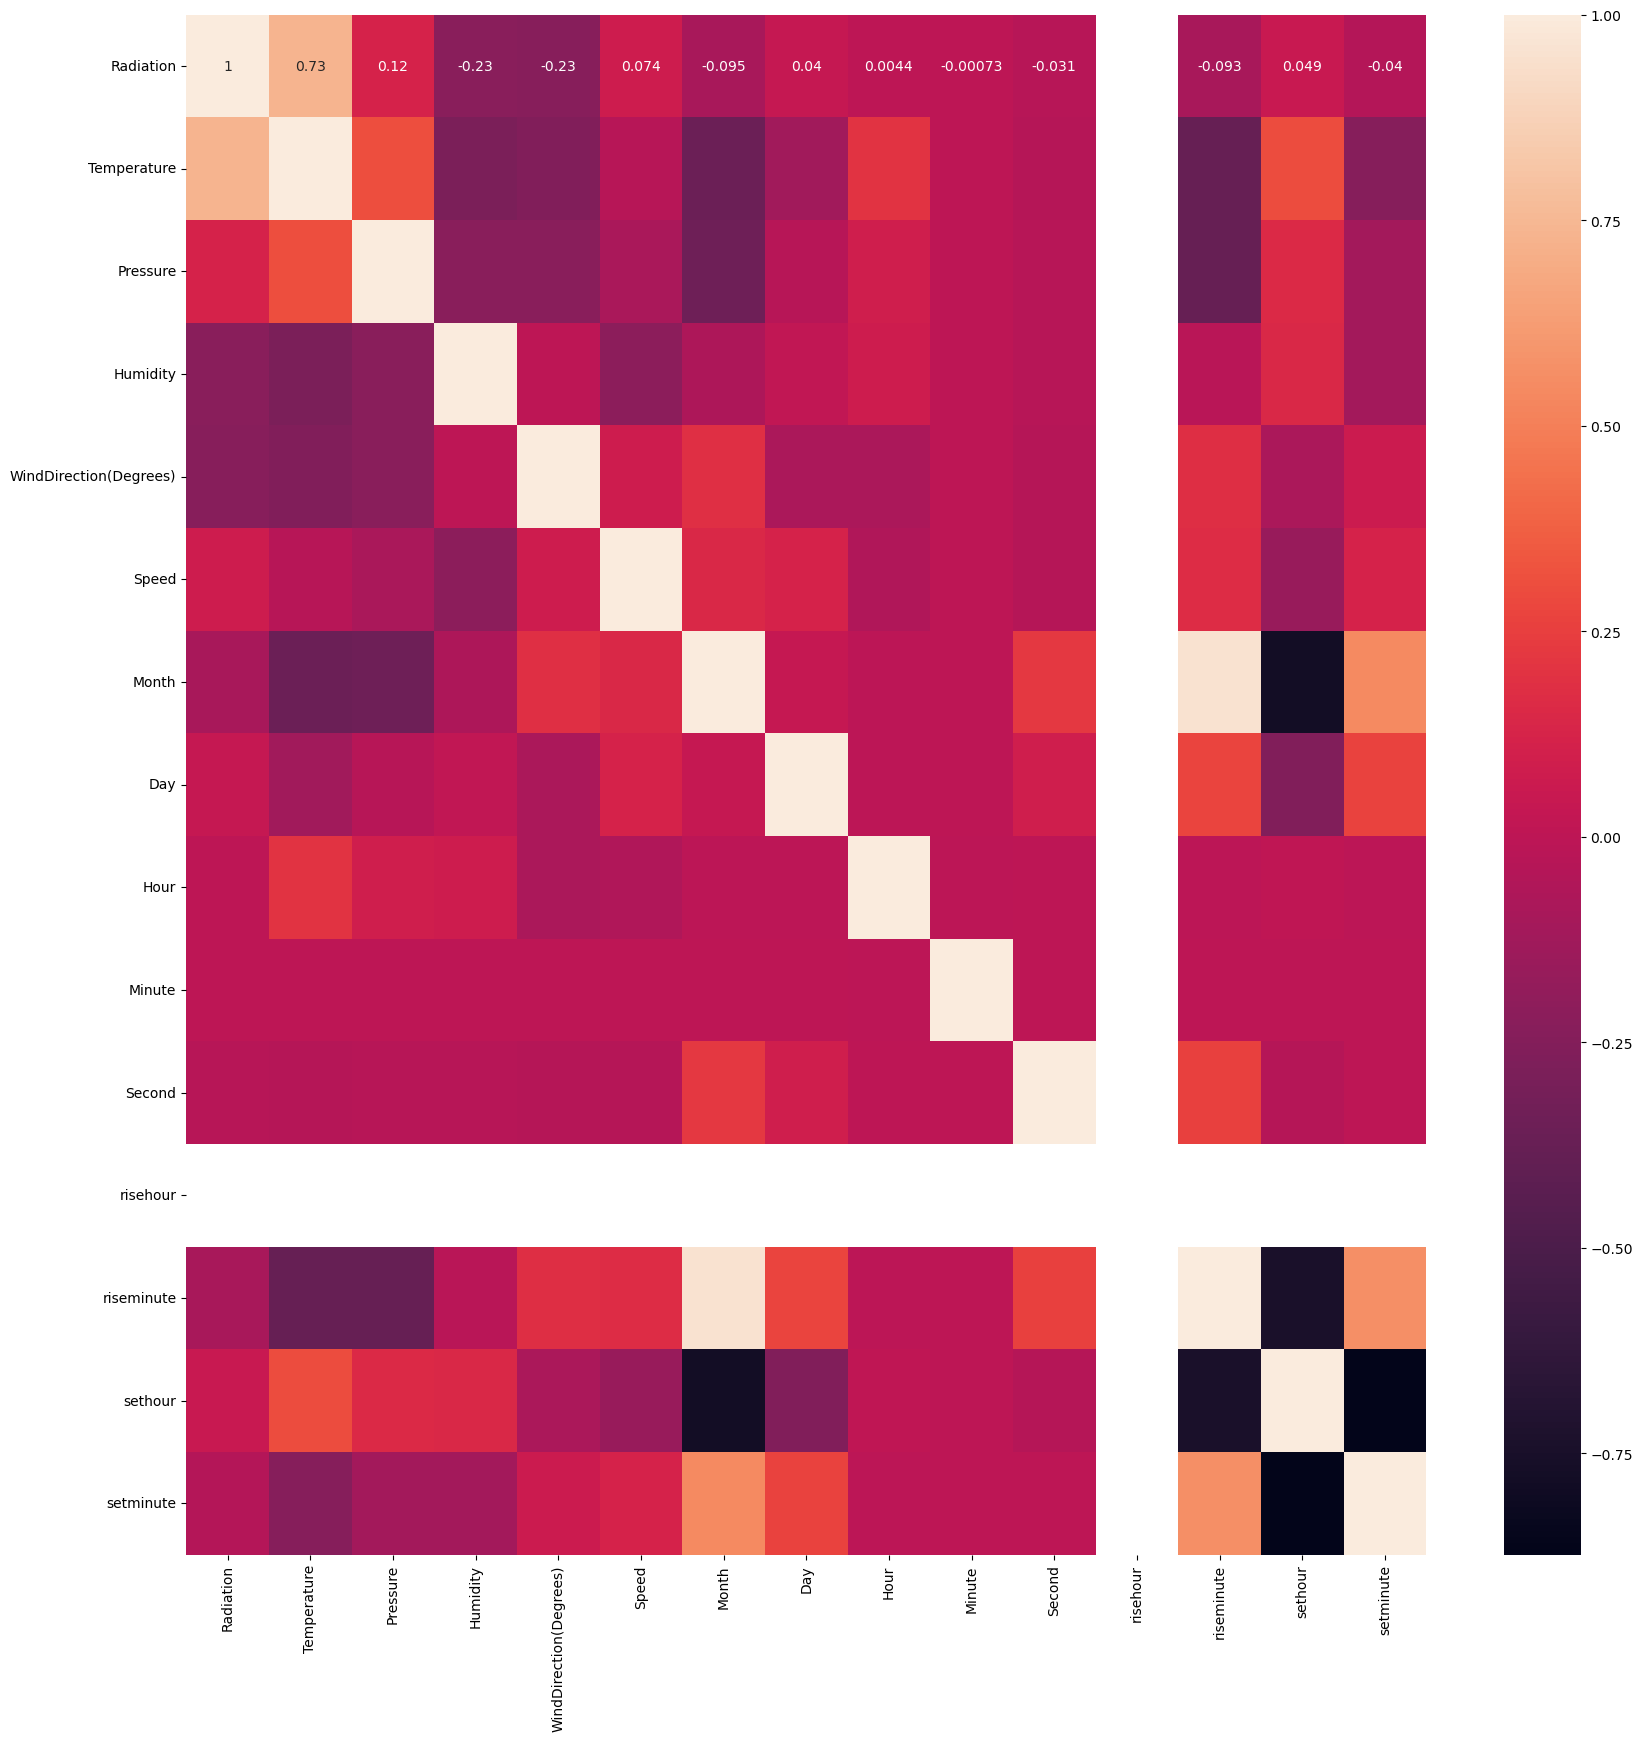

In [18]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True)
plt.show()

## <b/> Feature Selection using SelectKBest Method

In [19]:
bestFeatures = SelectKBest(score_func=chi2, k=10)

In [20]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# train_Y = le.fit_transform(target)

target_cont = df['Radiation'].apply(lambda x: int(x*100))

In [21]:
scaled_input_feature = MinMaxScaler().fit_transform(input_features)
fit = bestFeatures.fit(scaled_input_feature, target_cont)

In [22]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(input_features.columns)

In [23]:
featureScores = pd.concat([column, scores], axis=1)

In [24]:
featureScores.columns = ['features', 'feature_imp']

In [25]:
featureScores.sort_values(by='feature_imp', ascending=False, inplace=True)
featureScores

,features,feature_imp
12,sethour,12207.531454
5,Month,4684.579610
11,riseminute,4015.062771
3,WindDirection(Degrees),3271.827277
6,Day,2841.926850
8,Minute,2702.449333
9,Second,2288.673032
13,setminute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433


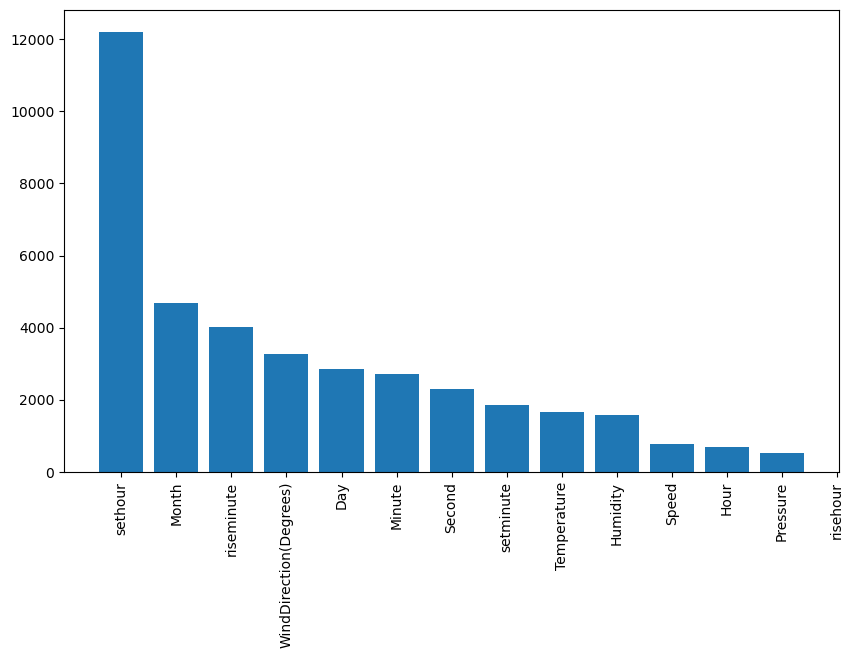

In [26]:
plt.figure(figsize=(10,6))
plt.bar(featureScores['features'], featureScores['feature_imp'])
plt.xticks(rotation=90)
plt.show()

## <b/> Feature Selection using Extra Tree Classsifier

In [27]:
model = ExtraTreesClassifier(n_estimators=5,verbose=2)
model.fit(scaled_input_feature, target_cont)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.4s finished


ExtraTreesClassifier(n_estimators=5, verbose=2)

In [28]:
feature_importances = pd.DataFrame(model.feature_importances_, index = input_features.columns, columns = ["feature_imp"])
feature_importances.sort_values(by = 'feature_imp', ascending=False, inplace = True)
feature_importances

,feature_imp
WindDirection(Degrees),0.160516
Minute,0.149039
Speed,0.125289
Second,0.123930
Humidity,0.109004
Hour,0.089998
Temperature,0.082458
Pressure,0.072813
Day,0.034574
setminute,0.024428


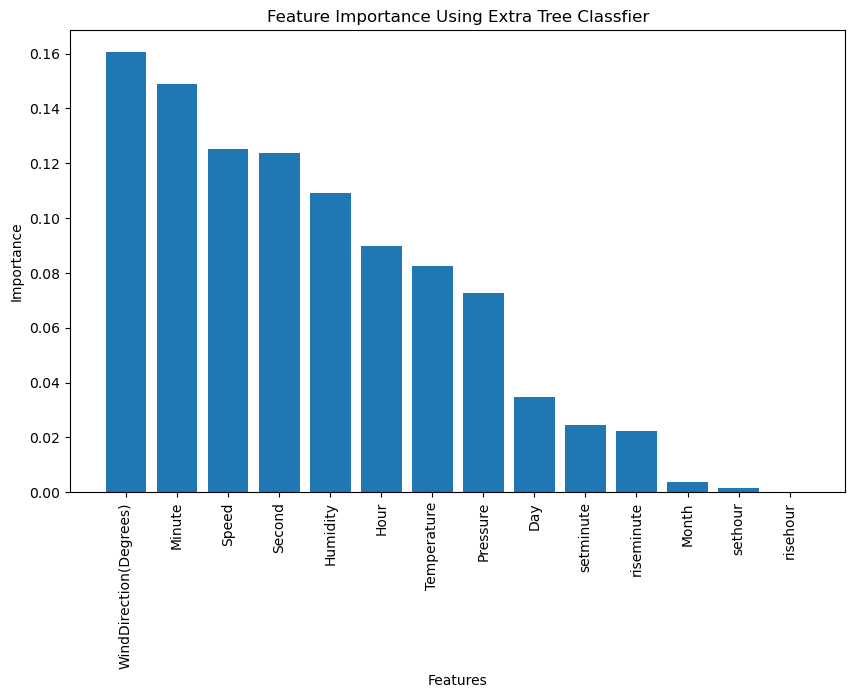

In [29]:
plt.figure(figsize=(10,6))
plt.bar(feature_importances.index, feature_importances['feature_imp'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Using Extra Tree Classfier')
plt.show()

## <b/> Feature Engineering using BoxCox, Log, Min-Max and Standard Transformation

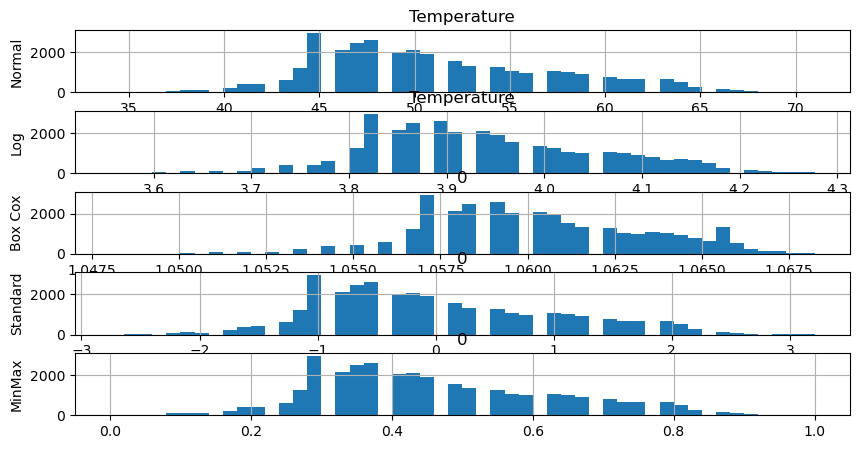

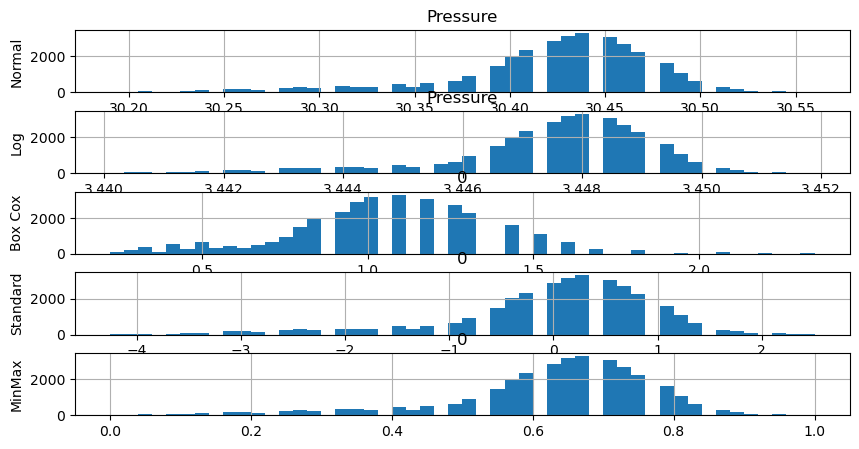

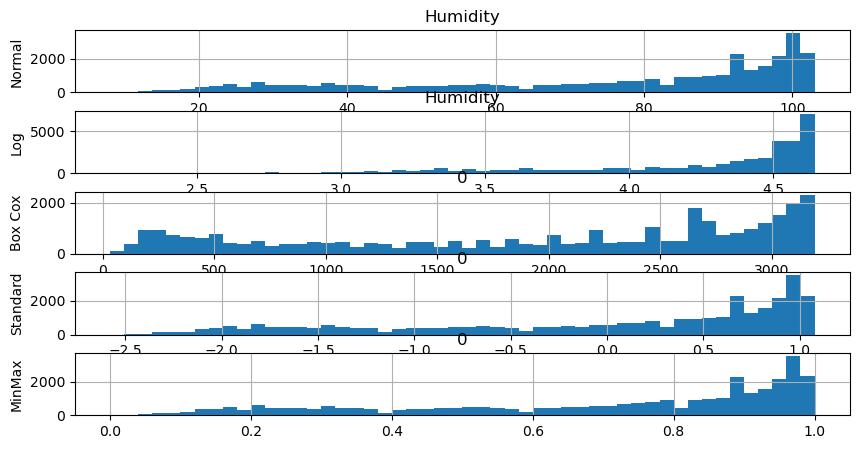

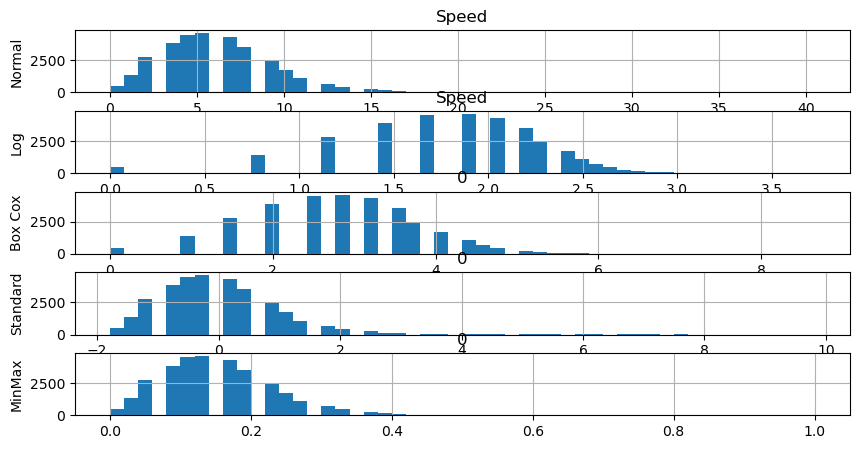

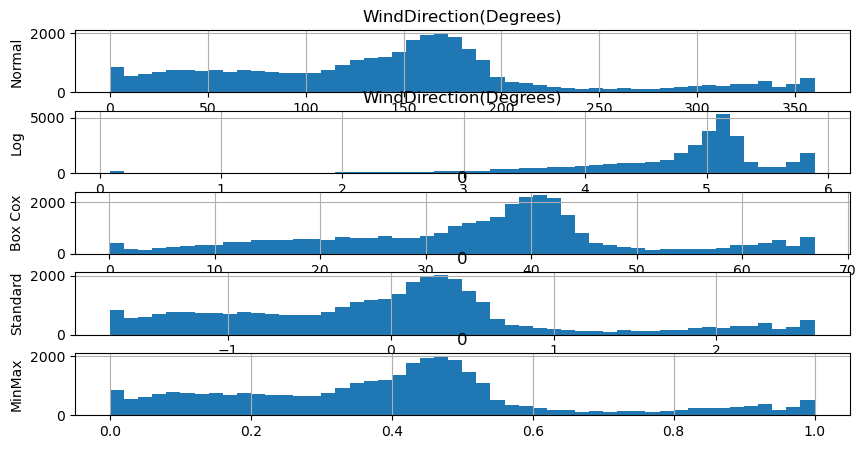

In [30]:
features_to_transform = ['Temperature', 'Pressure', 'Humidity', 'Speed', 'WindDirection(Degrees)']

for i in features_to_transform:
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 5))
    
    pd.DataFrame(input_features[i]).hist(ax = ax1, bins = 50)
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax = ax2, bins = 50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax = ax3, bins = 50)    
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax4, bins = 50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax5, bins = 50)
    
    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Box Cox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')

In [31]:
transform = {'Temperature' : (input_features['Temperature']+1).transform(np.log), 
             'Pressure': stats.boxcox(input_features['Pressure']+1)[0], 
             'Humidity' : stats.boxcox(input_features['Humidity']+1)[0], 
             'Speed' : (input_features['Speed']+1).transform(np.log), 
             'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    input_features[i] = transform[i]

In [32]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,3.89182,1.245999e+297,1139.358841,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,1.245999e+297,1104.047150,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,1.245999e+297,1069.253710,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,1.245999e+297,1175.187672,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,1.245999e+297,1248.392409,0.291391,1.890095,9,29,23,35,24,6,13,18,13


## <b/> Preparing Data - Standardization and Splitting

In [33]:
X_train, X_test, y_train, y_test = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
X_train.shape, X_test.shape

((26148, 14), (6538, 14))

## <b/> XGBoost Model - Predictions

In [35]:
from xgboost import XGBRegressor

params = {'learning_rate': 0.1,
          'max_depth': 8}

model = XGBRegressor(**params)

In [36]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [37]:
y_pred = model.predict(X_test)

In [38]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print('Testing Performance :')
print('RMSE : {:.2f}'.format(rmse))
print('R2 Score : {:.2f}'.format(r2))

Testing Performance :
RMSE : 83.01
R2 Score : 0.93


-----

## <b/> Model Prediction using Multi Layer Perceptron

In [39]:
model = None
model = Sequential()
    
model.add(Dense(128, activation='relu', input_dim=14))
model.add(Dropout(0.33))
    
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1, activation='linear'))
    
model.compile(metrics=['mse'], loss='mae', optimizer=Adam(learning_rate=0.001))
print(model.summary())

2024-04-03 23:13:35.968243: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-03 23:13:35.968297: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-03 23:13:35.968317: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-03 23:13:35.968605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-03 23:13:35.968639: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [40]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=32)

Epoch 1/50


2024-04-03 23:13:48.706636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


736/736 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 209.1525 - mse: 145061.2031 - val_loss: 203.9747 - val_mse: 136437.6406
Epoch 2/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 208.8909 - mse: 144488.9531 - val_loss: 203.4780 - val_mse: 136213.1875
Epoch 3/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 207.7757 - mse: 142915.9531 - val_loss: 203.4655 - val_mse: 136169.3750
Epoch 4/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 211.1732 - mse: 146186.1406 - val_loss: 203.4501 - val_mse: 136111.9531
Epoch 5/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 204.7771 - mse: 141579.3906 - val_loss: 203.4333 - val_mse: 136043.2812
Epoch 6/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 209.7516 - mse: 144984.0156 - val_loss: 203.4173 - val_mse: 135969.5625
Epoch 7/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 209.7974 - mse: 144302.8750 - val_loss: 203.4040 - val_mse: 135898.8906
Epoch 8/50
736/736 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 208.8916 - mse: 144005.5938

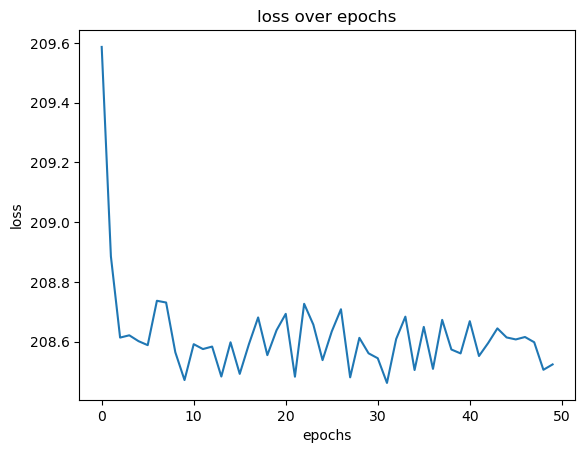

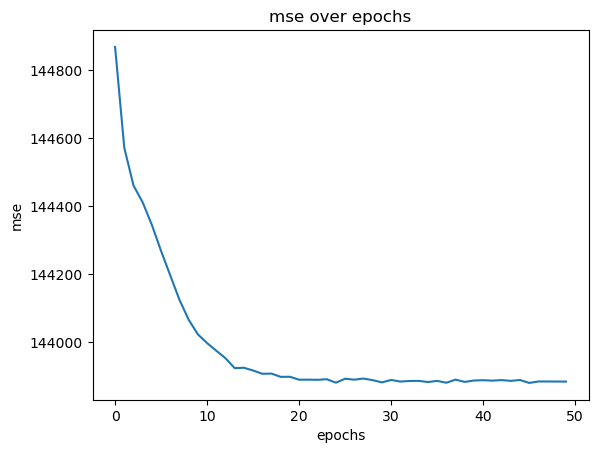

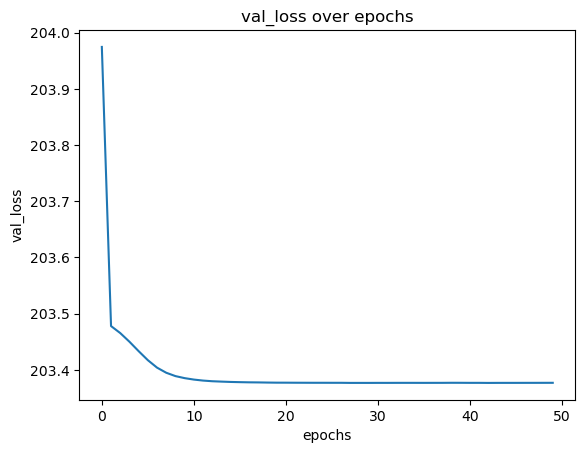

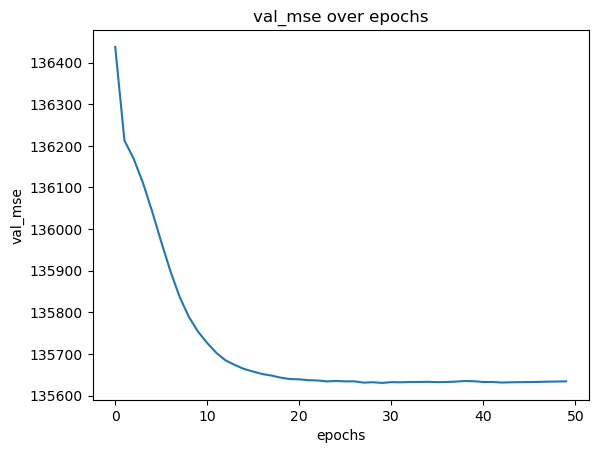

In [41]:
fit = history.history
for i in fit:
    plt.plot(fit[i])
    plt.title(i + ' over epochs')
    plt.ylabel(i)
    plt.xlabel('epochs')
    plt.show()

In [42]:
scores = model.evaluate(X_test, y_test)
mae = scores[0]
mse = scores[1]
print('Mean absolute error: ', mae)

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 203.0096 - mse: 139923.7812
Mean absolute error:  196.90708923339844


In [44]:
mean_absolute_error(y_test, model.predict(X_test))


205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


197.01040724443052